In [2]:
%pylab
%matplotlib inline

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

Файл:

In [3]:
image_file = get_pkg_data_filename('spirals/Sigma_S/arms_mask.fits')
image_data = fits.getdata(image_file, ext=0)

In [4]:
import ast

def get_all_original_segments(arm=None, **kwargs):
#     galname = kwargs['galname']
#     band = kwargs['band']
    coords = {}
    with open('spirals/Sigma_S/PGC0000_arm_tangents.reg', 'r') as file:
        for l in file.readlines():
            line = l[5:l.index(')')]
            x = ast.literal_eval(line)
            color = l[l.index('color=')+6:l.index('pitch=')].replace('  ', '')
            if color in coords.keys():
                coords[color].append(x)
            else:
                coords[color] = [x]
    if arm is None:
        return coords
    else:
        return {arm : coords[arm]}
    
    
def plot_skeleton(ax=None, lefts=None, rights=None, centers=None, color='k', **kwargs):
    if centers is None:
        assert len(lefts) == len(rights)
    else:
        assert len(lefts) == len(rights) == len(centers)
    
#     orig_center = kwargs['orig_center']
#     plot_center = kwargs['plot_center']
    
    def x_corr(x):
#         return -(x - orig_center[0]) + plot_center[0]
        return x
    
    def y_corr(y):
#         return y - orig_center[1] + plot_center[1]
        return y
    
    for i in range(len(lefts)):
#         ax.plot([lefts[i][0], rights[i][0]], [lefts[i][1], rights[i][1]], '-', color=color)
        ax.plot([x_corr(lefts[i][0]), x_corr(rights[i][0])], [y_corr(lefts[i][1]), y_corr(rights[i][1])], '-', color=color)
        if centers is not None:
            ax.scatter(x_corr(centers[i][0]), y_corr(centers[i][1]), 10,  color=color)
        

def plot_original_segments(ax=None, arm=None, **kwargs):
    coords = get_all_original_segments(arm=arm, **kwargs)
    
    try:
        orig_center = kwargs['orig_center']
        plot_center = kwargs['plot_center']
        def x_corr(x):
            return (x - orig_center[0]) + plot_center[0]
    
        def y_corr(y):
            return -(y - orig_center[1]) + plot_center[1]
    except:
        def x_corr(x):
            return x

        def y_corr(y):
            return y
    
    for k in coords.keys():
        lefts = []
        rights = []
        for tang in coords[k]:
            leftx,lefty,rightx,righty = tang
            lefts.append([x_corr(leftx),y_corr(lefty)])
            rights.append([x_corr(rightx),y_corr(righty)])
        plot_skeleton(ax=ax, lefts=lefts[1::2], rights=rights[1::2], centers=None, color=k, **kwargs)

Сами срезы:

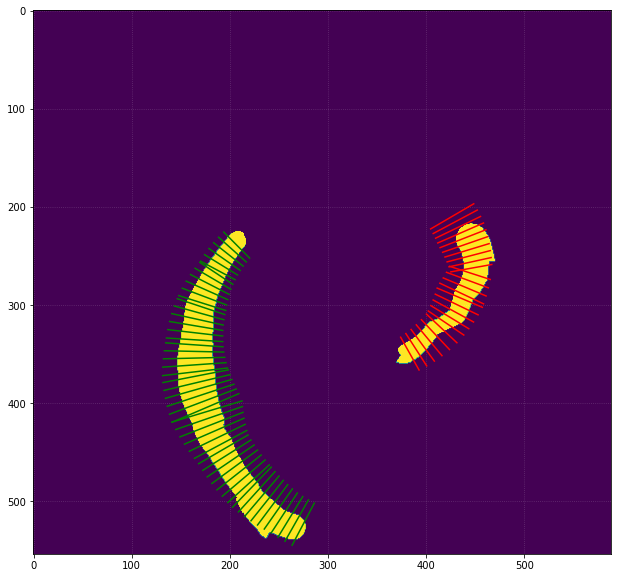

In [5]:
fig = plt.figure(figsize=[20,10])
ax = plt.subplot(111)

ax.imshow(image_data)

ax.grid(color='w', ls=':', alpha=0.2)
plot_original_segments(ax=ax, arm='red')
plot_original_segments(ax=ax, arm='green')


plt.show()

Положение пиков и ширин:

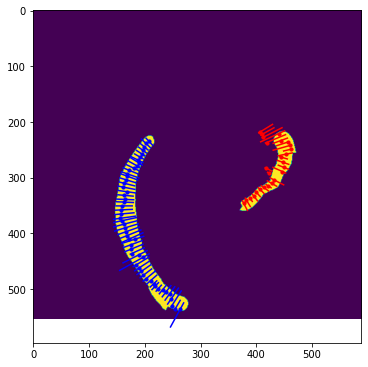

In [6]:
fig = plt.figure(figsize=[20,10])
ax = plt.subplot(131)

# arms_mask = get_arms_mask(**galdict)
# arms_mask = crop_by_radius(data=arms_mask, **galdict)
# plot_2d(ax=ax, data=arms_mask)

ax.imshow(image_data)

locs = np.genfromtxt('/mnt/sdb2/science/Course-work/NGC3627/spirals/Sigma_S/borders_red.dat')
for loc in locs:
    cx,cy,leftx,lefty,rightx,righty = loc
    plt.plot([leftx,rightx], [lefty,righty], '-', color='r')
    plt.scatter(cx,cy,10,color='r')
    
locs = np.genfromtxt('/mnt/sdb2/science/Course-work/NGC3627/spirals/Sigma_S/borders_green.dat')
for loc in locs:
    cx,cy,leftx,lefty,rightx,righty = loc
    plt.plot([leftx,rightx], [lefty,righty], '-', color='b')
    plt.scatter(cx,cy,10,color='b')
    
plt.show()

Функции чтобы считывать файл среза:

In [3]:
def read_slice_fit_params(path):
    '''parameters of slice fitting'''
    params = []
    with open(path) as inputf:
        lines = inputf.readlines()
        for l in lines[1:6]:
            param = float(l[l.index('=')+1:].replace('\n', ''))
            params.append(param)
    return params

def get_slice_data(path):
    sl_d = np.genfromtxt(path)
    t = sl_d[:, 0]
    y = sl_d[:, 1]
    yerr = sl_d[:, 2]
    return t,y,yerr
    
    
def gaussian_lopsided(dist, params):
    # Unpack params
    amplitude = params[0]
    peak_pos = params[1]
    width_left = params[2]
    width_right = params[3]
    # Compute exponential rise and decay
    flux = np.zeros_like(dist) + amplitude
    left_idx = dist <= peak_pos
    right_idx = dist > peak_pos
    flux[left_idx] *= np.exp(-((dist[left_idx] - peak_pos)**2) / (width_left**2))
    flux[right_idx] *= np.exp(-((dist[right_idx] - peak_pos)**2) / (width_right**2))
    return flux


def get_slice_data_and_fit(slice_path, arm=None, slice_num=None):
    slicef = slice_path + '/slice_{}_{}.dat'.format(arm, slice_num)
    params = read_slice_fit_params(slicef)
    dist, obs, obs_err = get_slice_data(slicef)
    fitted = gaussian_lopsided(dist, params)
    return dist, obs, obs_err, fitted

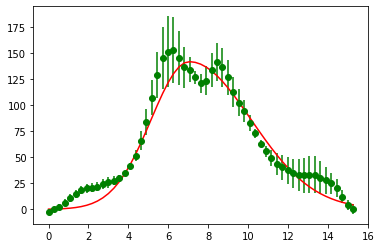

In [5]:
dist, obs, obs_err, fitted = get_slice_data_and_fit('spirals/Sigma_S', arm='green', slice_num='005')
plt.errorbar(dist, obs, yerr=obs_err, color='g', fmt='o')
plt.plot(dist, fitted, '-', color='r')
plt.show()

Итеррирование по срезам (добавление нулей в начале):

In [6]:
arm = 'green'
blue_arm = np.genfromtxt('spirals/Sigma_S/arm_params_{}.dat'.format(arm))
blue_arm_yy = blue_arm[:, 7]

for ii in range(1, len(blue_arm_yy)+1):
    if ii < 10:
        istr = '00'+str(ii)
    elif ii < 100:
        istr = '0'+str(ii)
    else:
        istr = str(ii)

    try:
        print(istr)
        get_slice_data_and_fit('spirals/Sigma_S', arm=arm, slice_num=istr)
    except Exception as e:
        print(e)

001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
